# 1. Setup and Get Data

## 1.1 Install Dependencies and Setup

In [ ]:
#!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

## 1.2 Collect Images Using OpenCV

In [1]:
import os
import time
import uuid  # unique user identification
import cv2

In [2]:
# we should have an empty data folder in current working directory and an images folder inside it
# Lets join the path so that we can access saved images in this folder and save images in this folder
IMAGES_PATH = os.path.join('data','images')

# we will take imgaes in batch of the following number i-e 30 images in one batch then change outfit 
# then take 30 images in next batch and so on
number_images = 30

In [8]:
# lets make connection to video  for me it is webcam number 0 but for you it can be 1 or 2
cap = cv2.VideoCapture(0)

In [17]:
# Lets loop through range of images aka 'number_images'
for imgnum in range(number_images):
    # first we will print image number
    print(f'Collecting image {imgnum}')
    
    # then we are gonna read from our capture device
    ret, frame = cap.read()
    
    # Lets write the name of the file using uuid
    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
                           
    # write the image using cv2.imwrite()
    cv2.imwrite(imgname, frame)
    
    # we are also gonna show the image on screen
    cv2.imshow('frame', frame)
    
    # lets set a delay time between the images for moving around
    time.sleep(0.5)
    
    # usual cv2 break loop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release
cv2.destroyAllWindows()   

### **Move around and run the above code to take images in batches of 30. I ran this code 3 times, so I have taken 90 images so far**
___

## 1.3 Annotateing the images with LabelMe

In [18]:
!labelme

[INFO   ] font_manager:_rebuild:1337 - generated new fontManager
[INFO   ] font_manager:_rebuild:1337 - generated new fontManager
[INFO   ] __init__:get_config:71 - Loading config file from: C:\Users\salma\.labelmerc


## Instructions
1. Go to Open Dir and select the images folder
2. Then go to File -> Change Output Directory -> select Labels folder
3. Go to File -> Save Automatically
4. Go to Edit -> Create Rectangle
5. Click on top and then drag and then click on bottom and a pop up windo appears and give label a name (I gave it face)
6. Hit D to move to next image and keep on doing that

# 2. Review Dataset and Building an Image Loading Function for TF

## 2.1 Importing dependencies and Libraries

In [22]:
import tensorflow as tf
import json                # our labels are in json format so we need it
import numpy as np
import matplotlib.pyplot as plt

## 2.2 Load Images in TF Data Pipeliene

In [46]:
# *.jpg is a wild card search look for anything with .jpg file format
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [47]:
# Lets check if it is picking up the images if not then its not gonna throw an error 
# so this step is very important
images.as_numpy_iterator().next()

b'data\\images\\6100abba-19ec-11ed-ba63-58fb84383140.jpg'

In [48]:
# Now we are gonna write a function that will load the images
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [49]:
# We will use map function to read the images
images = images.map(load_image)

In [50]:
# Lets check if the images are loaded
images.as_numpy_iterator().next()

array([[[185, 192, 200],
        [184, 191, 199],
        [185, 192, 200],
        ...,
        [172, 183, 187],
        [172, 183, 187],
        [173, 184, 188]],

       [[185, 192, 200],
        [184, 191, 199],
        [185, 192, 200],
        ...,
        [171, 182, 186],
        [172, 183, 187],
        [173, 184, 188]],

       [[184, 193, 200],
        [183, 192, 199],
        [184, 193, 200],
        ...,
        [171, 182, 186],
        [172, 183, 187],
        [172, 183, 187]],

       ...,

       [[ 40,  49,  56],
        [ 40,  49,  56],
        [ 42,  51,  60],
        ...,
        [ 24,  27,  32],
        [ 24,  29,  33],
        [ 24,  29,  33]],

       [[ 45,  48,  55],
        [ 47,  51,  60],
        [ 51,  55,  66],
        ...,
        [ 25,  28,  33],
        [ 24,  29,  33],
        [ 22,  30,  33]],

       [[ 46,  46,  54],
        [ 49,  49,  57],
        [ 49,  51,  63],
        ...,
        [ 27,  32,  36],
        [ 28,  33,  37],
        [ 26,  34,  37]]

In [51]:
# checking the type of images, they should be tensorflow dataset pipeline
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

## 2.3 Visualizing the Raw Images using Matplotlib

In [52]:
# lets generate images in batches
image_generator = images.batch(4).as_numpy_iterator()

In [63]:
# This will get the next batch of 4
plot_images = image_generator.next()

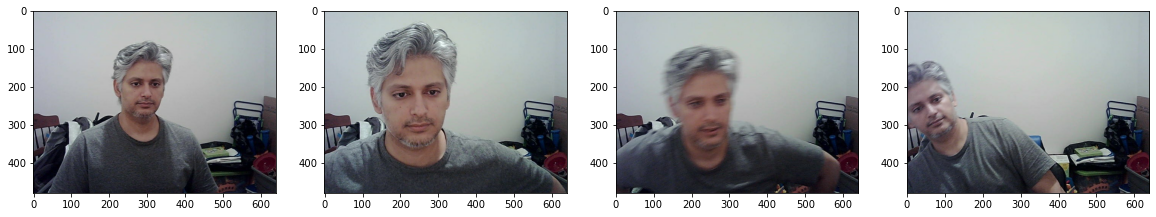

In [64]:
# Lets visualize the current batch
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

## 3.1 I will be splitting the data manually

1. We have total of 90 images
2. I will put 70% of the images in train folder i-e **62**
3. 15% in val and 15% in test i-e **14 each**

## 3.2 Moving the Matching Labels

In [62]:
# Looping through the train test and val folder to move the matching labels respectively
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      